#Crime Prediction in Communities

### Resolving external depdencies

In [ ]:
pip install boto3==1.26.90

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: boto3
    Found existing installation: boto3 1.26.133
    Uninstalling boto3-1.26.133:
      Successfully uninstalled boto3-1.26.133


In [ ]:
pip install s3fs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import boto3
import s3fs

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K

from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm
import tensorflow as tf

from getpass import getpass

### Pulling data from Amazon S3

In [ ]:
# Set random seed for reproducibility 
np.random.seed(89)

# Enter authentication credentials

BUCKET_NAME = 'crimes-in-communities-bucket'

AWS_ACCESS_KEY_ID = getpass('Enter AWS_ACCESS_KEY_ID: ')
AWS_SECRET_ACCESS_KEY = getpass('Enter AWS_SECRET_ACCESS_KEY: ')

KEY = 'CommViolPredUnnormalizedData.txt' 

# Create Pandas Dataframe reading from Amazon S3 Storage
df = pd.read_csv('s3://' + BUCKET_NAME + '/'+ KEY,
                 storage_options={'key': AWS_ACCESS_KEY_ID,
                           'secret': AWS_SECRET_ACCESS_KEY})


Enter AWS_ACCESS_KEY_ID: ··········
Enter AWS_SECRET_ACCESS_KEY: ··········


### Data Preprocessing and Exploration

In [ ]:
df = df.replace('?',np.NaN) # Replace '?' with NaN values to be preprocessed 
df = df.set_index('communityname') # Use community name as our index

# We also remove columns of string values that represent locations of each datapoint, keeping the "communityname" as our form of indexing
locVar = ['state','countyCode','communityCode','fold']
df = df.drop(locVar, axis = 1)
df = df.apply(pd.to_numeric, errors='coerce' ) # Change entry types of items in df as floating point / integer values

In [ ]:
df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
communityname,,,,,,,,,,,,,,,,,,,,,
BerkeleyHeightstownship,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,...,14.0,114.85,138.0,1132.08,16.0,131.26,2.0,16.41,41.02,1394.59
Marpletownship,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,...,57.0,242.37,376.0,1598.78,26.0,110.55,1.0,4.25,127.56,1955.95
Tigardcity,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,...,274.0,758.14,1797.0,4972.19,136.0,376.30,22.0,60.87,218.59,6167.51
Gloversvillecity,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,...,225.0,1301.78,716.0,4142.56,47.0,271.93,NaN,NaN,306.64,NaN
Bemidjicity,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,...,91.0,728.93,1060.0,8490.87,91.0,728.93,5.0,40.05,NaN,9988.79


In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 2215 entries, BerkeleyHeightstownship to WestSacramentocity
Data columns (total 142 columns):
 #    Column                 Dtype  
---   ------                 -----  
 0    population             int64  
 1    householdsize          float64
 2    racepctblack           float64
 3    racePctWhite           float64
 4    racePctAsian           float64
 5    racePctHisp            float64
 6    agePct12t21            float64
 7    agePct12t29            float64
 8    agePct16t24            float64
 9    agePct65up             float64
 10   numbUrban              int64  
 11   pctUrban               float64
 12   medIncome              int64  
 13   pctWWage               float64
 14   pctWFarmSelf           float64
 15   pctWInvInc             float64
 16   pctWSocSec             float64
 17   pctWPubAsst            float64
 18   pctWRetire             float64
 19   medFamInc              int64  
 20   perCapInc              int64  
 21   whit

In [ ]:
# As we are predicting a specific crime per population, we drop columns that are essentially duplicates of our targets (e.g: we drop murders as we are predicting murderPerPop)
# The "per population" statistic gives us the number of occurances per 100k.

redundantTargets = ['murders','rapes', 'robberies','assaults','burglaries','larcenies','autoTheft','arsons']
targetCols = ['murdPerPop', 'rapesPerPop', 'robbbPerPop', 'assaultPerPop','burglPerPop', 'larcPerPop','autoTheftPerPop','arsonsPerPop']
df = df.drop(redundantTargets, axis = 1)

# We additionally remove columns for non violent and violent crimes per population as they are a cummulation of the 8 target variables we predict.
cumulativeTargets = ['ViolentCrimesPerPop', 'nonViolPerPop']
df = df.drop(cumulativeTargets, axis = 1)

In [ ]:
df.describe()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LemasPctOfficDrugUn,PolicBudgPerPop,murdPerPop,rapesPerPop,robbbPerPop,assaultPerPop,burglPerPop,larcPerPop,autoTheftPerPop,arsonsPerPop
count,2.215000e+03,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,...,2215.000000,3.430000e+02,2215.000000,2007.00000,2214.000000,2202.000000,2212.000000,2212.000000,2212.000000,2124.000000
mean,5.311798e+04,2.707327,9.335102,83.979819,2.670203,7.950176,14.445837,27.644840,13.975142,11.836393,...,0.980163,1.535779e+05,5.859296,36.25848,162.612597,378.004605,1033.430203,3372.979150,473.965628,32.153682
std,2.046203e+05,0.334120,14.247156,16.419080,4.473843,14.589832,4.518623,6.181517,5.970747,4.777565,...,2.877128,2.030409e+05,9.156829,34.23975,234.486624,438.238599,763.354442,1901.316145,504.666026,39.240900
min,1.000500e+04,1.600000,0.000000,2.680000,0.030000,0.120000,4.580000,9.380000,4.640000,1.660000,...,0.000000,1.526040e+04,0.000000,0.00000,0.000000,0.000000,16.920000,77.860000,6.550000,0.000000
25%,1.436600e+04,2.500000,0.860000,76.320000,0.620000,0.930000,12.250000,24.415000,11.320000,8.750000,...,0.000000,8.809435e+04,0.000000,11.53500,27.647500,94.187500,511.690000,2040.080000,156.952500,7.670000
50%,2.279200e+04,2.660000,2.870000,90.350000,1.230000,2.180000,13.620000,26.780000,12.540000,11.730000,...,0.000000,1.145820e+05,2.170000,26.92000,74.800000,226.525000,822.715000,3079.510000,302.355000,21.080000
75%,4.302400e+04,2.850000,11.145000,96.225000,2.670000,7.810000,15.360000,29.205000,14.345000,14.415000,...,0.000000,1.556557e+05,8.365000,51.47000,187.155000,504.387500,1350.232500,4335.410000,589.775000,42.852500
max,7.322564e+06,5.280000,96.670000,99.630000,57.460000,95.290000,54.400000,70.510000,63.620000,52.770000,...,48.440000,2.422367e+06,91.090000,401.35000,2264.130000,4932.500000,11881.020000,25910.550000,4968.590000,436.370000


In [ ]:
df.shape

(2215, 132)

In [ ]:
df.columns

Index(['population', 'householdsize', 'racepctblack', 'racePctWhite',
       'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29',
       'agePct16t24', 'agePct65up',
       ...
       'LemasPctOfficDrugUn', 'PolicBudgPerPop', 'murdPerPop', 'rapesPerPop',
       'robbbPerPop', 'assaultPerPop', 'burglPerPop', 'larcPerPop',
       'autoTheftPerPop', 'arsonsPerPop'],
      dtype='object', length=132)

In [ ]:
df.index

Index(['BerkeleyHeightstownship', 'Marpletownship', 'Tigardcity',
       'Gloversvillecity', 'Bemidjicity', 'Springfieldcity', 'Norwoodtown',
       'Andersoncity', 'Fargocity', 'Wacocity',
       ...
       'Weatherfordcity', 'Duncancity', 'WestHaventown', 'Willistoncity',
       'Manvilleborough', 'Mercedcity', 'Pinevillecity', 'Yucaipacity',
       'Beevillecity', 'WestSacramentocity'],
      dtype='object', name='communityname', length=2215)

In [ ]:
pd.set_option('display.max_rows', 500)
print("Percentage of Missing Values of Each Column:\n\n")
print(df.isnull().sum()/df.shape[0])

Percentage of Missing Values of Each Column:


population               0.000000
householdsize            0.000000
racepctblack             0.000000
racePctWhite             0.000000
racePctAsian             0.000000
racePctHisp              0.000000
agePct12t21              0.000000
agePct12t29              0.000000
agePct16t24              0.000000
agePct65up               0.000000
numbUrban                0.000000
pctUrban                 0.000000
medIncome                0.000000
pctWWage                 0.000000
pctWFarmSelf             0.000000
pctWInvInc               0.000000
pctWSocSec               0.000000
pctWPubAsst              0.000000
pctWRetire               0.000000
medFamInc                0.000000
perCapInc                0.000000
whitePerCap              0.000000
blackPerCap              0.000000
indianPerCap             0.000000
AsianPerCap              0.000000
OtherPerCap              0.000451
HispPerCap               0.000000
NumUnderPov              0.000000
P

####Data Imputation

In [ ]:
n = df.shape[0]

pd.set_option('display.max_rows', 500)

# Find the count of zero valued entries for each column 
n_zeros = (n - np.count_nonzero(df, axis = 0))/float(n)

# Omit columns that have more that 75% of values being zero
col_zero_gt_75 = []
for i in range(len(df.columns)):
  if n_zeros[i]>.75:
    col_zero_gt_75.append(df.columns[i])

df = df.drop(columns = col_zero_gt_75 )

pd.reset_option('display.max_rows')

# If 80 percent of values of a given feature are missing, we drop the column
df = df.dropna(axis=1, thresh=int(.2*df.shape[0]), inplace=False)


# Separate into Training and Test Data
train, test = train_test_split(df, test_size=0.2)

In [ ]:
## Imputation using mean and median 
# Pros: Fast and useful for small datasets
# Cons: Does not make use of column wise relationships

# column_means = df.mean(axis=0, skipna=True)
# df.fillna(column_means, axis = 0, inplace = True)

# column_medians = df.median(axis=0, skipna=True)
# df.fillna(column_medians, axis = 0, inplace = True)


## Imputation using most frequent or constant value 
# col_mostFreq = df.mode()[df.columns].iloc[0]
# df.fillna(col_mostFreq, axis = 0, inplace = True)


## Imputation using KNN (Feature simularity to predict missing value)
# Pros: Can be more accurate than prior methods - takes into account cross-column relationships
# Cons: Computationaly expensive, Sensitive to outliers

# imputer = KNNImputer(n_neighbors=10, weights="uniform")
# imputer.fit(train)
# train = imputer.transform(train)


##Imputation using MICE Algorithm
# Aribitrarily initialize values for missing feature values. Iteratively impute predicted values
# of missing attributes using combination of other features using random forests. Conclude with 
# convergence of values.

imputer = IterativeImputer(max_iter=10, random_state=0)
imputer.fit(train)
train = imputer.transform(train)

# We drop any columns missing any target values in our test partition
# We intentionally dont keep datapoints without missing values for a test set to 
# avoid introducing arbitrary bias in our model prediction

test.dropna(axis=0, how='any', subset=targetCols, inplace=True)

# We impute features in our test set to assist with our target predictions
test = imputer.transform(test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but IterativeImputer was fitted without feature names
  warnings.warn(


In [ ]:
# Construct Dataframe for Test and Training Set
train = pd.DataFrame(data = train, columns = df.columns)
test = pd.DataFrame(data = test, columns = df.columns)

# Confirm the lack of missing values
pd.set_option('display.max_rows', 500)
print("Missing Values Each Column (Train):\n\n")
print(train.isnull().sum())
print('\n')
print("Missing Values Each Column (Test):\n\n")
print(test.isnull().sum())

pd.reset_option('display.max_rows')

Missing Values Each Column (Train):


population               0
householdsize            0
racepctblack             0
racePctWhite             0
racePctAsian             0
racePctHisp              0
agePct12t21              0
agePct12t29              0
agePct16t24              0
agePct65up               0
numbUrban                0
pctUrban                 0
medIncome                0
pctWWage                 0
pctWFarmSelf             0
pctWInvInc               0
pctWSocSec               0
pctWPubAsst              0
pctWRetire               0
medFamInc                0
perCapInc                0
whitePerCap              0
blackPerCap              0
indianPerCap             0
AsianPerCap              0
OtherPerCap              0
HispPerCap               0
NumUnderPov              0
PctPopUnderPov           0
PctLess9thGrade          0
PctNotHSGrad             0
PctBSorMore              0
PctUnemployed            0
PctEmploy                0
PctEmplManu              0
PctEmplProfServ  

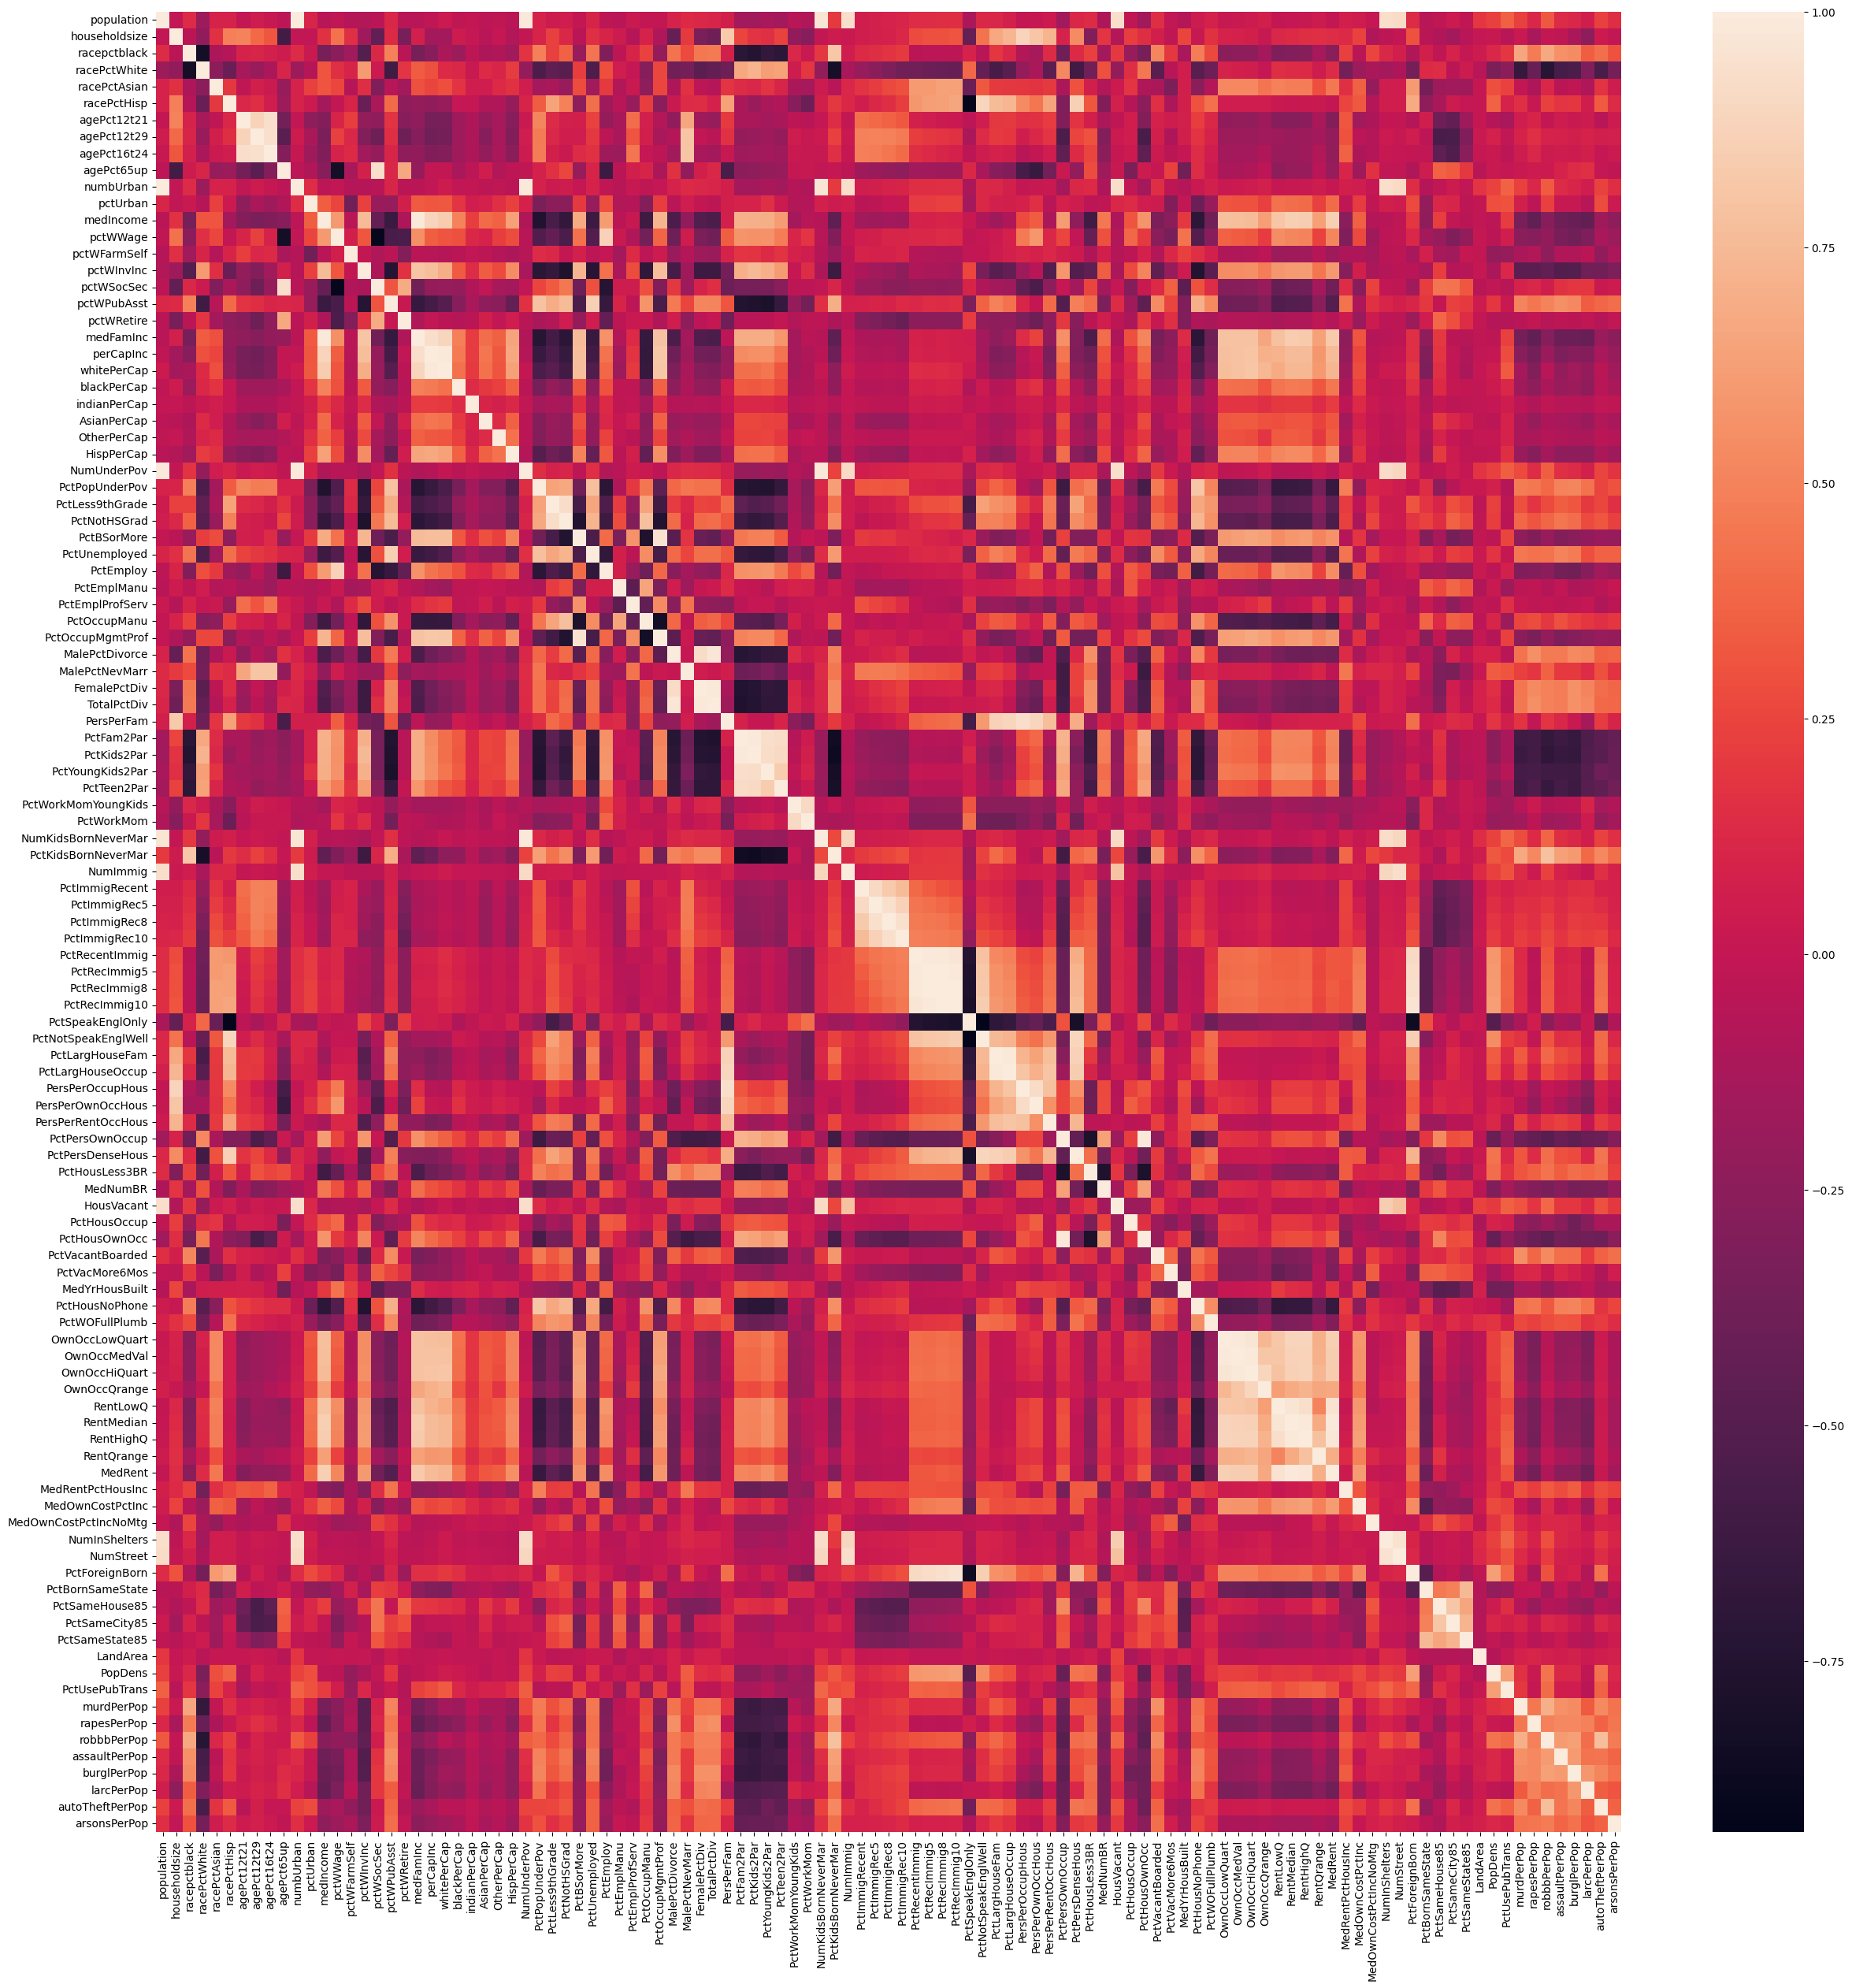

In [ ]:
# Display the correlation between features using Seaborn Heatmap

plt.figure(figsize=(30, 30))
ax = sns.heatmap(train.corr())

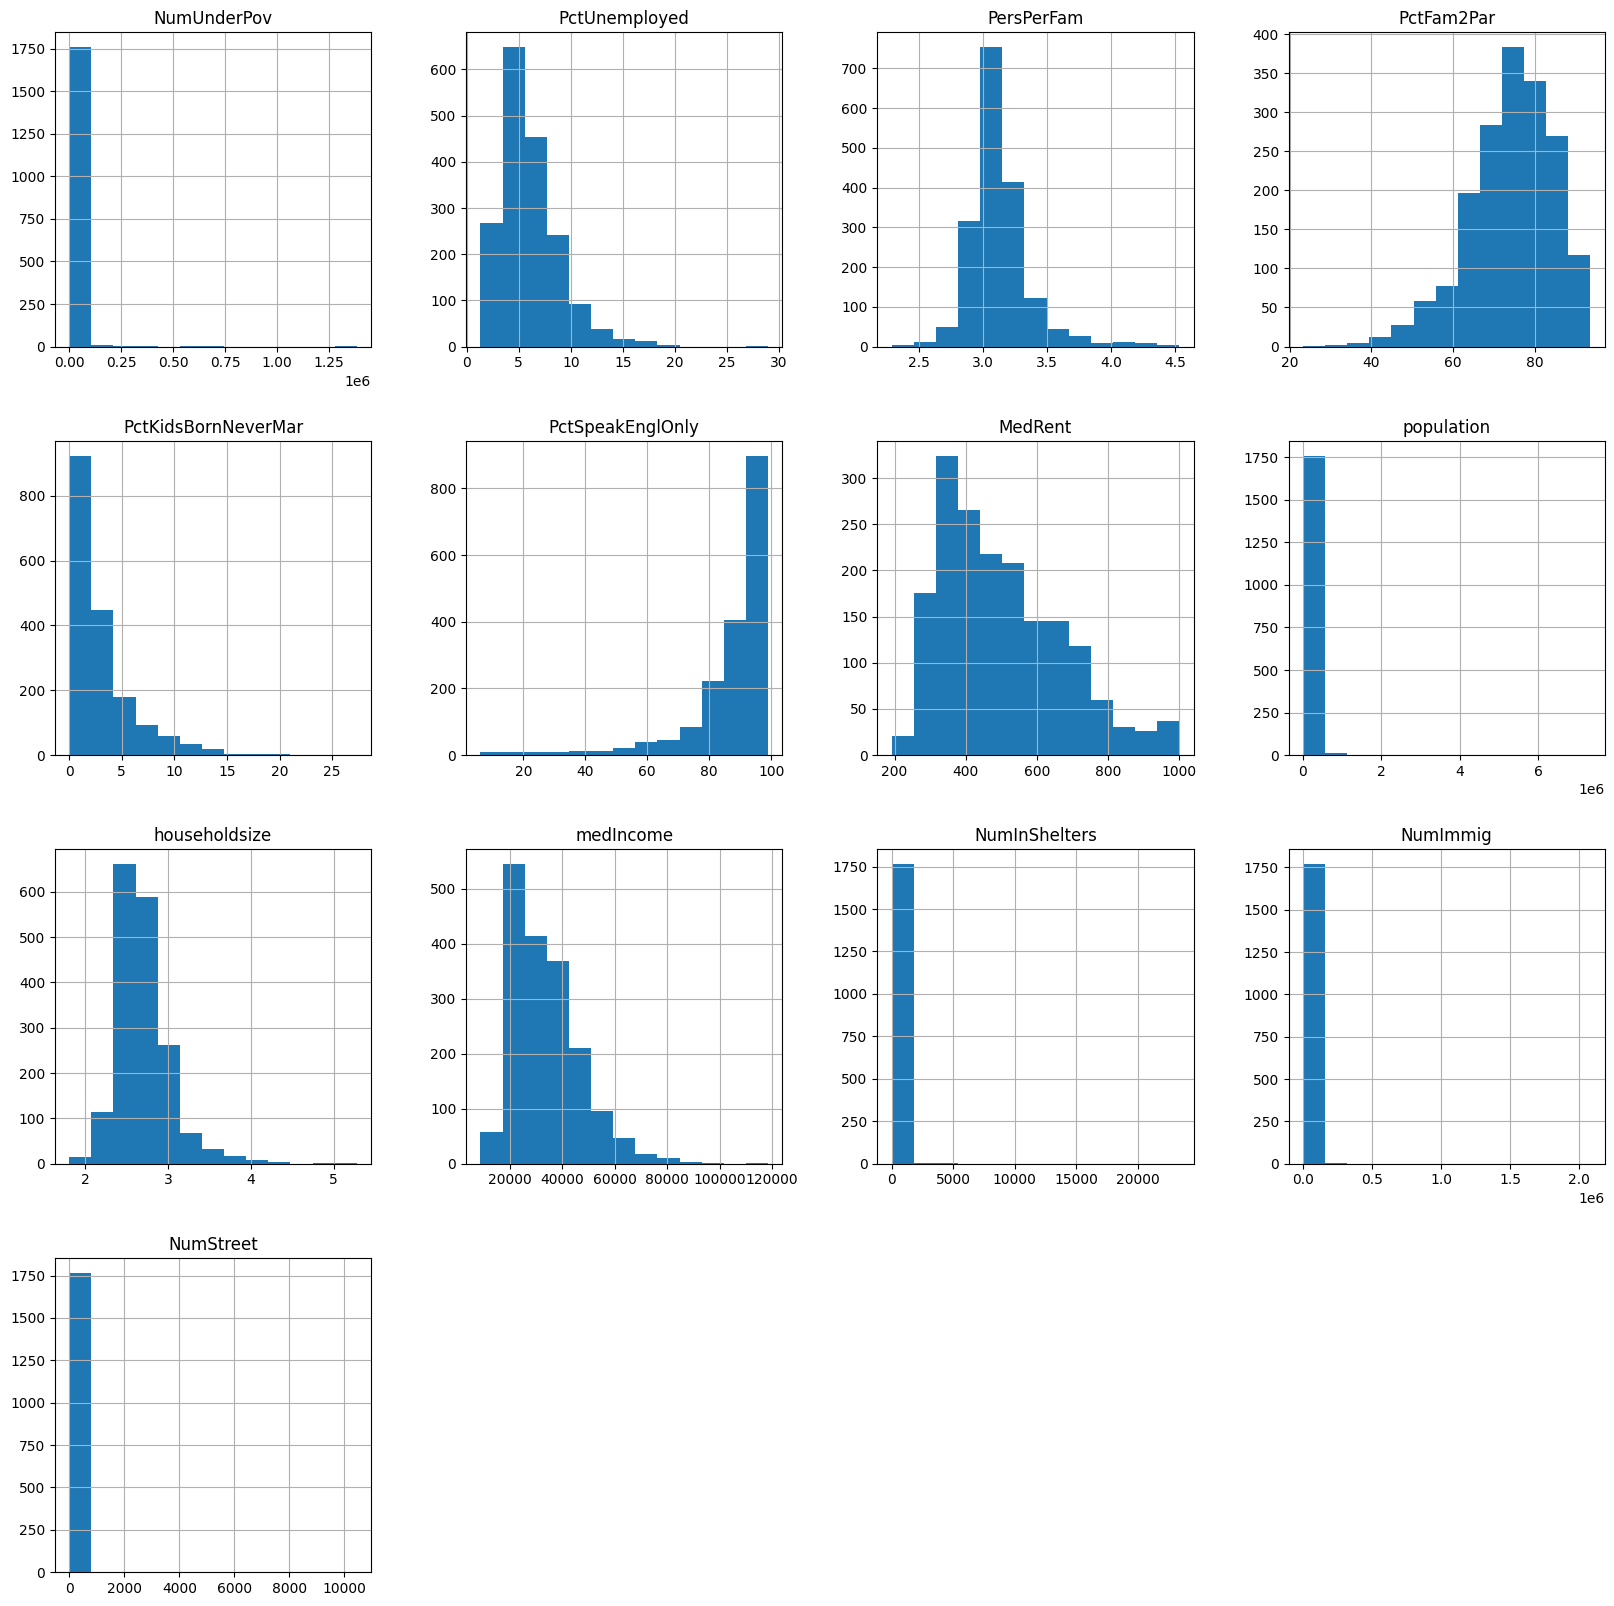

In [ ]:
# Choosing subset of columns for Data Exploration / Visualization
col_race_pct =["racepctblack","racePctWhite","racePctAsian","racePctHisp"]
col_other_of_interest = ["NumUnderPov","PctUnemployed","PersPerFam","PctFam2Par", "PctKidsBornNeverMar", "PctSpeakEnglOnly", "MedRent", "population", "householdsize", "medIncome", "NumInShelters", "NumImmig","NumStreet"]

#Histogram of values and occurances for choosen features
train[col_other_of_interest].hist(bins=13, figsize=(20, 20), layout=(4, 4));

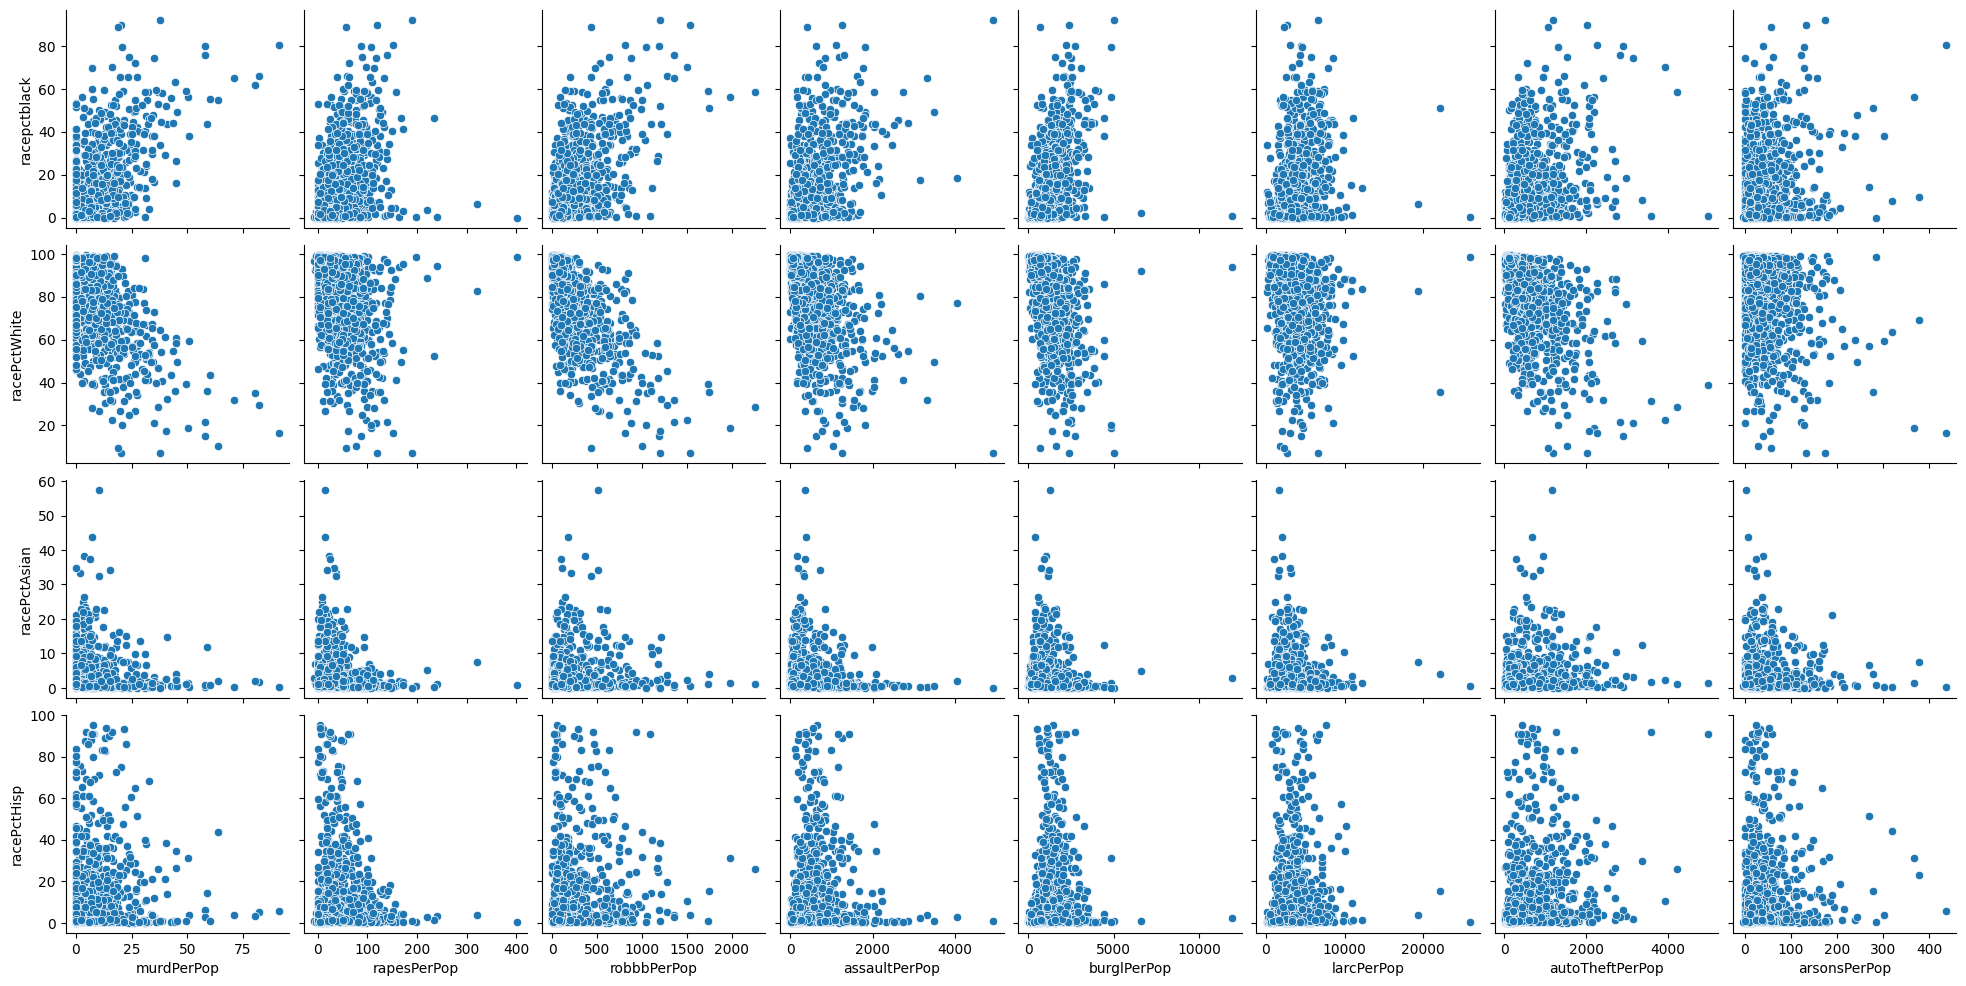

In [ ]:
# Visualizing spread of data when seeing the occurances of crime vs. percentage of different races in communities

sns.pairplot(train,
              x_vars=targetCols,
              y_vars=col_race_pct)

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:235: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


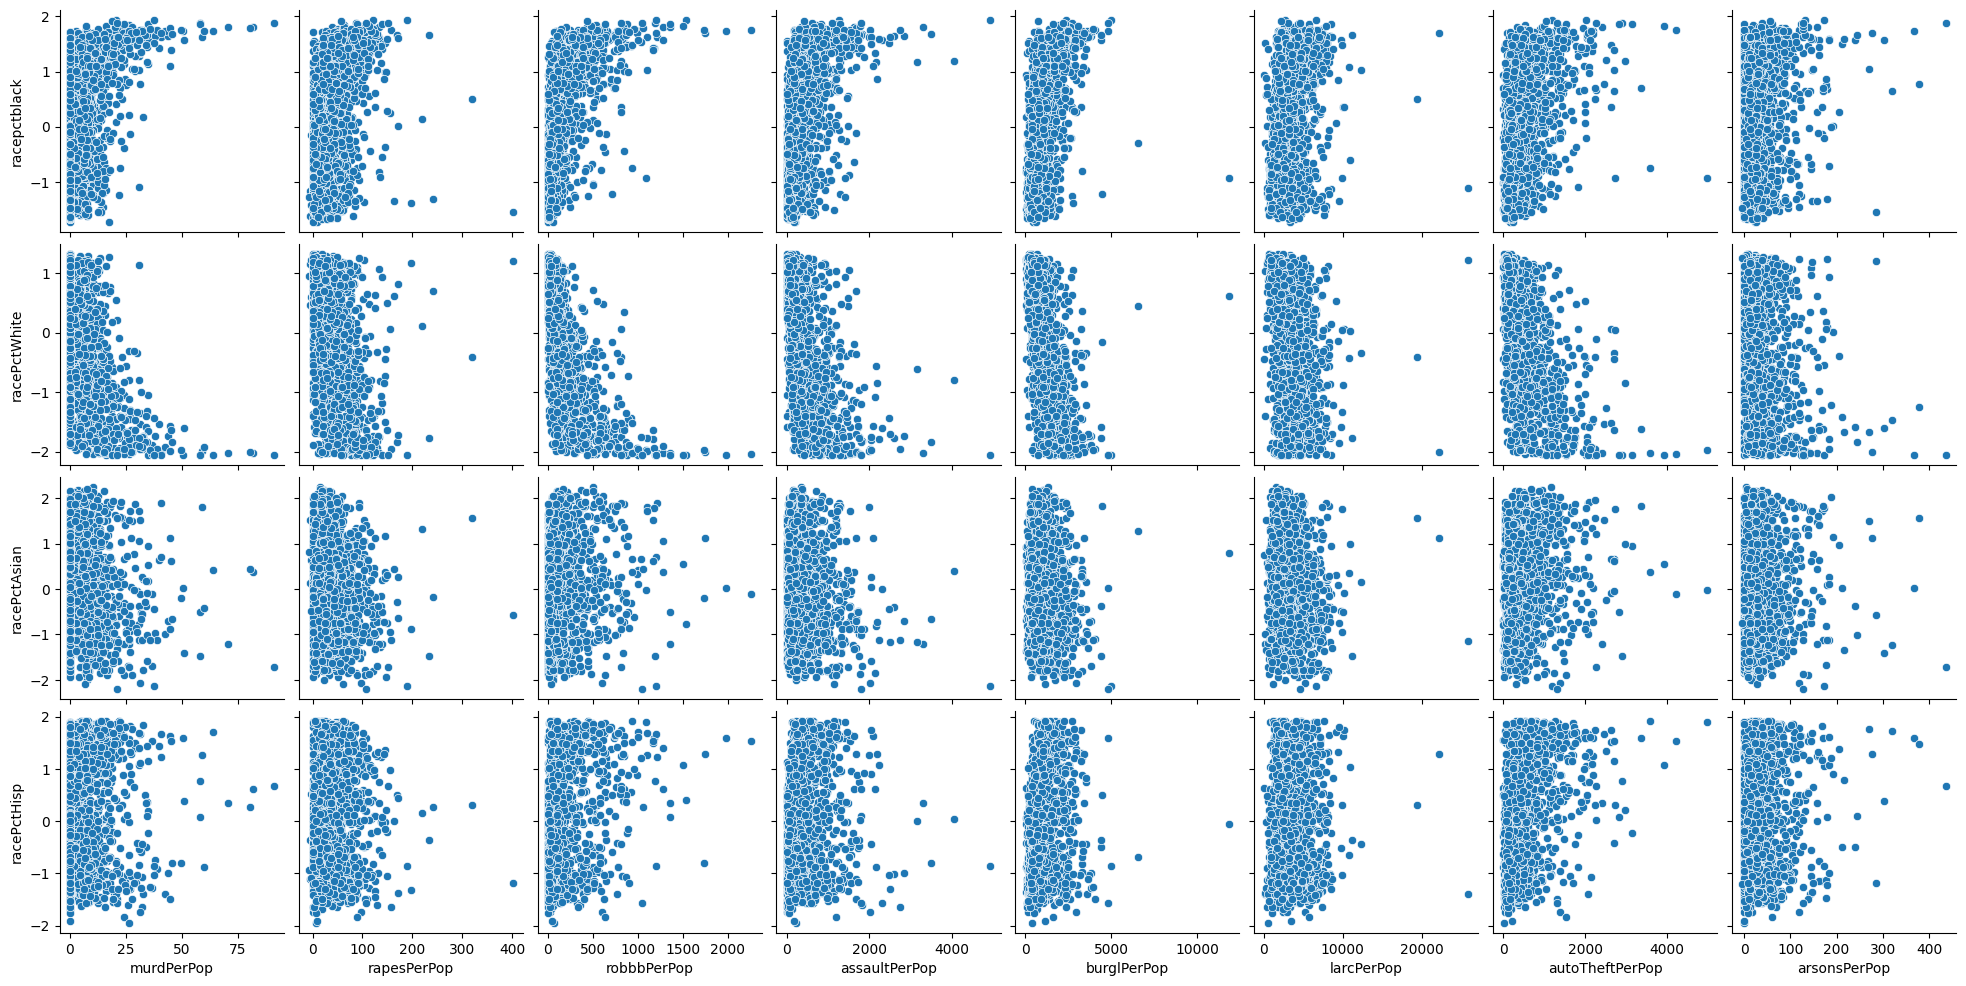

In [ ]:
# Split Training and Test Set into Features and Target Variables
train_x = train.drop(targetCols, axis=1)
train_y = train[targetCols]
test_x = test.drop(targetCols, axis=1)
test_y = test[targetCols]


# Normalizing features to be more "Gaussian-like" using Yeo-Johnson transform. Using maximum-likelihood,
# the optimal parameters are determined to stabilize variance and minimize skewness.
# Zero-mean and unit variance was especially helpful as we perform regression over principle components
# (PCA is sensitive to standardization)
pt = preprocessing.PowerTransformer()
pt.fit(train_x)

trans_trainx = pt.transform(train_x)
trans_testx = pt.transform(test_x)


# We observe the impact of normalization using the transform by viewing the above plots
# with the normalized data

dfx_int = pd.DataFrame(data = trans_trainx,index=train_x.index, columns = train_x.columns)

result = pd.concat([train_y,dfx_int], axis=1, join='inner')

sns.pairplot(result,
              x_vars=targetCols,
              y_vars=col_race_pct)

In [ ]:
# Preprocessing of Target Variables:
# As determined when viewing the Pandas Dataframe, the values of the target variables
# vary largely. To address this, we utilize sklearn's StandardScaler, removing the mean
# from feature values and scaling to unit variance
# z = (x - u) / s
s = preprocessing.StandardScaler()
s.fit(train_y)

train_y = s.transform(train_y)
test_y = s.transform(test_y)

Cumulative explained variance: 0.9661223957441413


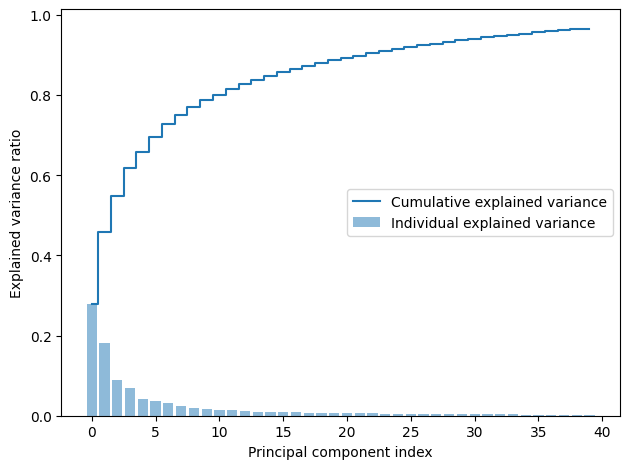

In [ ]:
# Perform PCA to avoid issues of multicollinearity (affecting training stability and 
# generalizability). Multicollinearity, an issue especially prevalent in social data,
# essentially is the expressability of inputs using other inputs. 

# Retain 95% explained variance using highest 40 PCs

pca = PCA(n_components=40)
pca.fit(trans_trainx)

exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.

cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Create the visualization plot
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
print("Cumulative explained variance: " + str(cum_sum_eigenvalues[-1]))
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='center right')
plt.tight_layout()
plt.show()

pca_trainx = pca.transform(trans_trainx)
pca_testx = pca.transform(trans_testx)

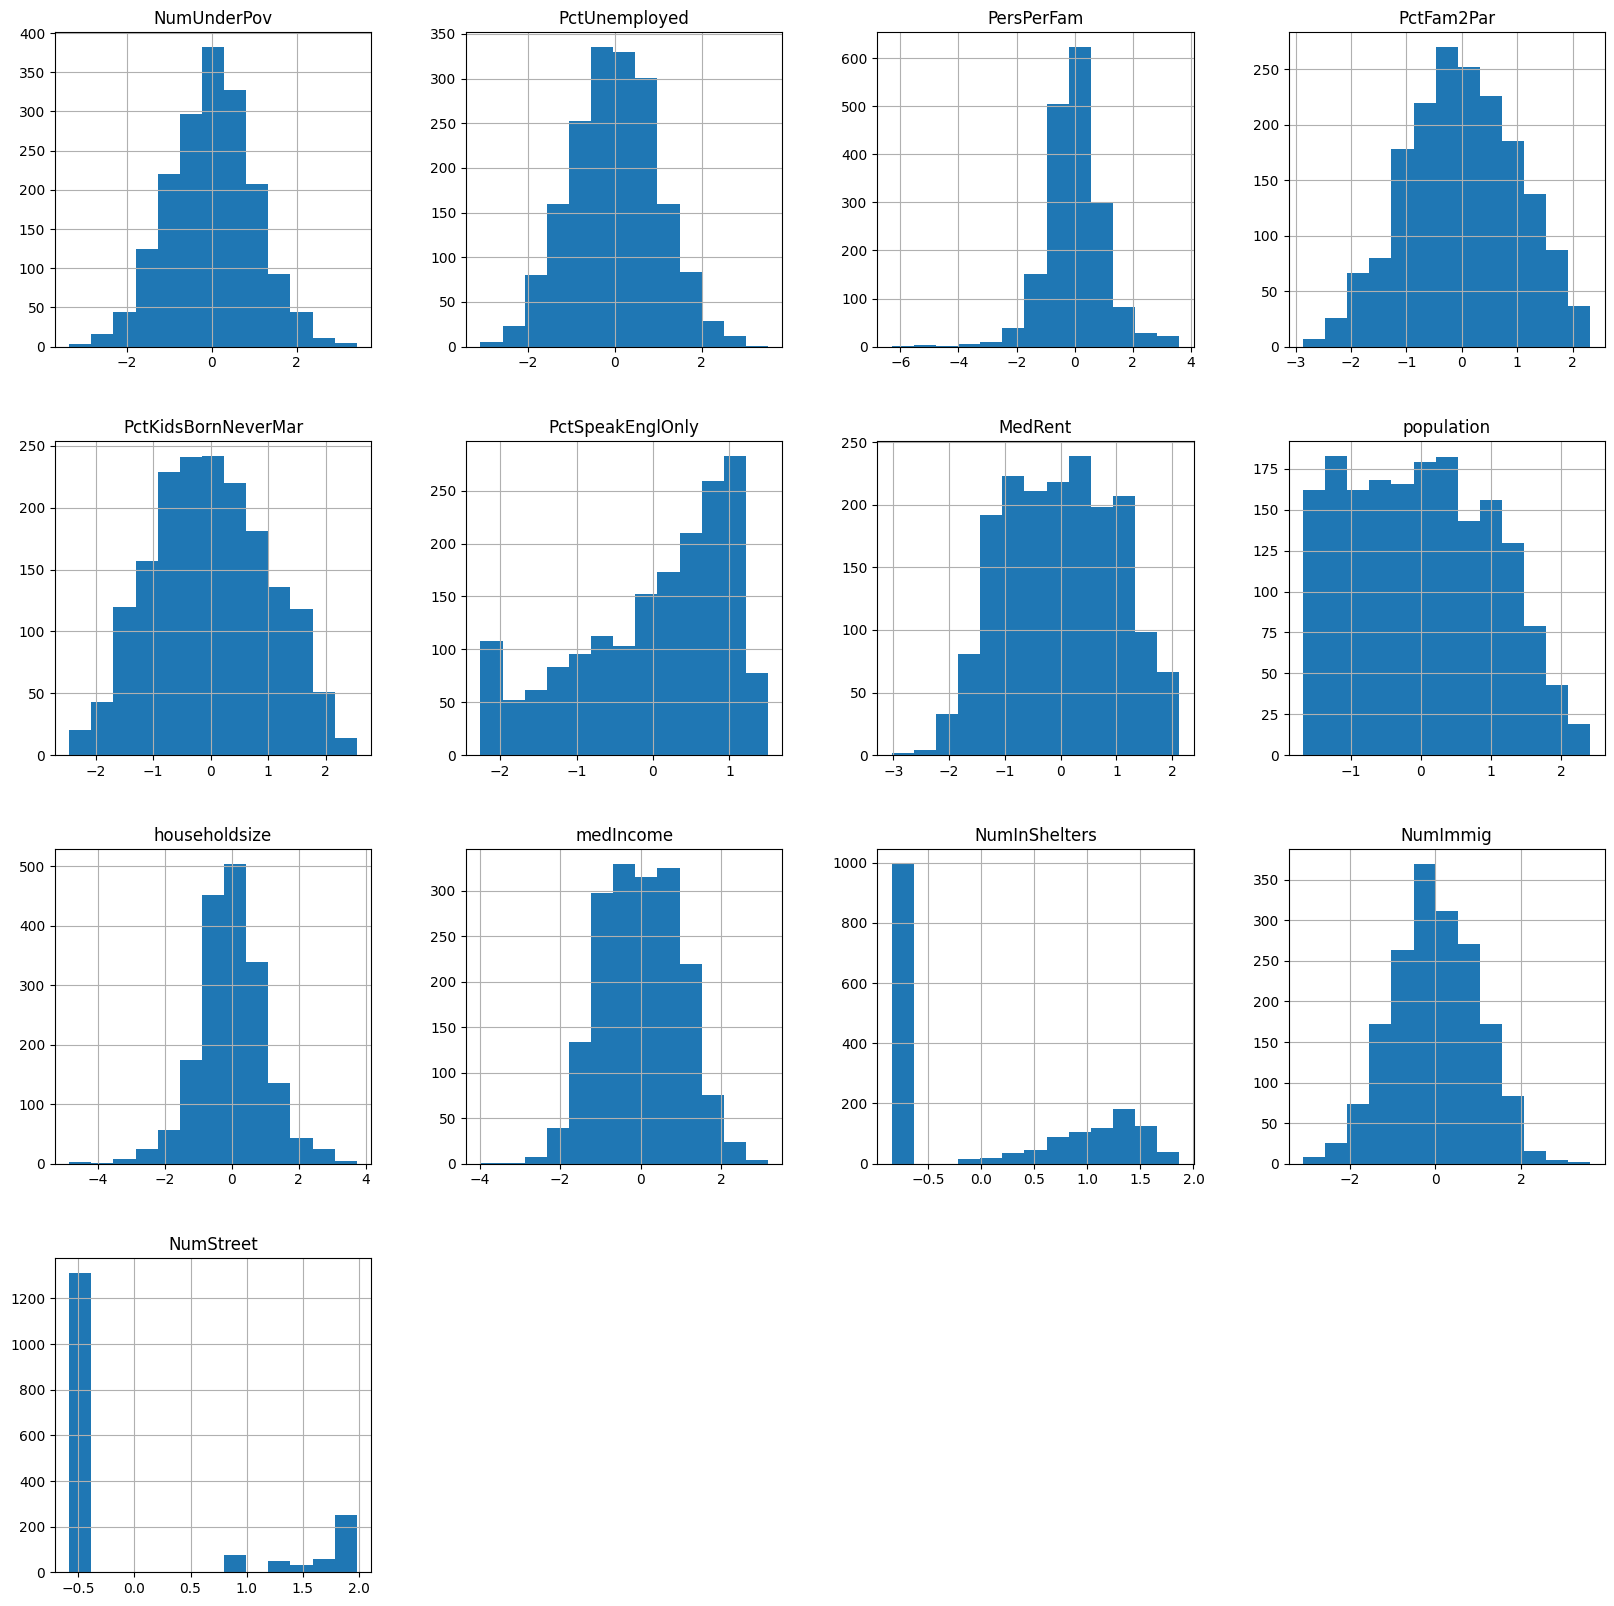

In [ ]:
#Further visualization of feature historgrams post pre-processing
result[col_other_of_interest].hist(bins=13, figsize=(20, 20), layout=(4, 4));

In [ ]:
# Function to "untransform" y values; needed due to inverse_transform not compatable 
# with keras when calculating model metrics
def untransform_y(yy):
  return (yy * s.scale_) + s.mean_

# Compute the symmetric mean absolute percentage error (sMAPE)
# Accuracy metric based on relative percentage error
def smape(y_true, y_pred):
    yt = untransform_y(y_true)
    yp = untransform_y(y_pred)
    return K.mean(K.abs(yt - yp) / (K.abs(yt) + K.abs(yp) + K.epsilon()))

# Compute the sMAPE for every output feature
def smape_single(y_true, y_pred):
    yt = untransform_y(y_true)
    yp = untransform_y(y_pred)
    return np.mean(np.abs(yt - yp) / (np.abs(yt) + np.abs(yp) + K.epsilon()), axis=0)

# Compute the Mean R-Squared (goodness-of-fit) across all outputs
# R-Squared is also termed the standardized version of MSE. R-squared represents the 
# fraction of variance of the actual value of the response variable captured by the regression model 
# rather than the MSE which captures the residual error.
def mrs(y_true, y_pred):
    """Computes the mean R-squared (goodness-of-fit) across all outputs"""
    yt = untransform_y(y_true)
    yp = untransform_y(y_pred)

    ybar = K.mean(yt, axis=0)
    ss_tot = K.sum(K.square(yt - ybar), axis=0)
    ss_res = K.sum(K.square(yt - yp), axis=0)
    rsq = 1 - (ss_res / (ss_tot + K.epsilon()))
    return K.mean(rsq)

# Computes the standard deviation of R-squared across all outputs
def stdrs(y_true, y_pred):
    yt = untransform_y(y_true)
    yp = untransform_y(y_pred)

    ybar = K.mean(yt, axis=0)
    ss_tot = K.sum(K.square(yt - ybar), axis=0)
    ss_res = K.sum(K.square(yt - yp), axis=0)
    rsq = 1 - (ss_res / (ss_tot + K.epsilon()))
    return K.std(rsq)

In [ ]:
# Retrieve number of features input in first layer of NN model
num_x_feats = pca_trainx.shape[1]

def regression_model(reg=None):
    model = Sequential()

    # Contracting architecture of two hidden layers with ReLU activation units  
    # Weights initialized using Xavier uniform initializer (kernel_initializer='glorot_uniform')
    model.add(Dense(40, activation= 'relu', input_shape=(num_x_feats,), kernel_initializer='glorot_uniform', kernel_regularizer=reg))
    model.add(Dense(20, activation= 'relu', kernel_initializer='glorot_uniform', kernel_regularizer=reg))
    model.add(Dense(8, activation='linear'))

    # For our loss function rather than using MSE, we look for a loss function that 
    # is less penalizing comparatively of larger deviations of the target and predicted
    # values. High accuracy in one target var. may result in poor predictions of the 
    # remaining. As we want generalizability and the utilization of relationship 
    # between target metrics, we hope to avoid this case scenario. Log-cosh and 
    # the huber loss function exhibit this behavior, having similar form of MSE close
    # to zero and a decline in slope comparatively as the error becomes larger.

    # To assist with optimization, we utilize momentum, using the accumulation of previous 
    # gradients in addition to gradients of a current time step
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum = .90), loss= "logcosh", metrics=[mrs, stdrs, smape])
    # model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.00001), loss= tf.keras.losses.binary_crossentropy, metrics=[mrs, stdrs, smape])


    # Other optimizers of use: tf.keras.optimizers.Adam, etc.
    # Other loss functions of use: "Huber", etc.

    model.summary()
    return model


model = regression_model(tf.keras.regularizers.L2(0.005))

# Accumulation of metrics (MRS, STDRS, sMAPE) during training
history = model.fit(pca_trainx, train_y, batch_size=32, epochs=500, verbose=True)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 40)                1640      
                                                                 
 dense_19 (Dense)            (None, 20)                820       
                                                                 
 dense_20 (Dense)            (None, 8)                 168       
                                                                 
Total params: 2,628
Trainable params: 2,628
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
56/56 [==============================] - 3s 10ms/step - loss: 0.8193 - mrs: -1.1125 - stdrs: 1.2624 - smape: 0.5103
Epoch 2/500
56/56 [==============================] - 0s 6ms/step - loss: 0.6633 - mrs: -0.2679 - stdrs: 0.4650 - smape: 0.4441
Epoch 3/500
56/56 [==============================] - 0s 5ms/s

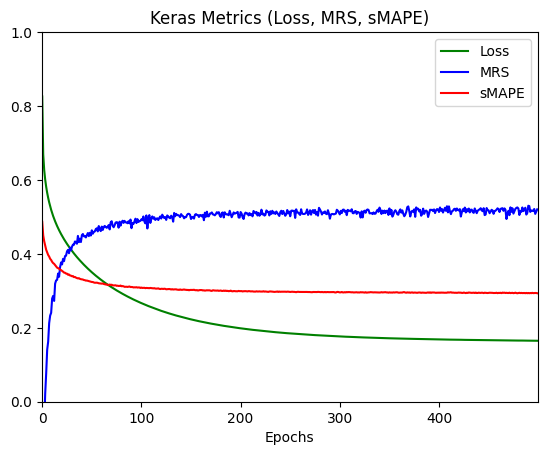

In [ ]:
# Plotting Keras Metrics
plt.ylim((0, 1))
plt.plot(history.history['loss'], 'g-', label = "Loss")
plt.plot(history.history['mrs'], 'b-',label = "MRS")
plt.plot(history.history['smape'], 'r-',label = "sMAPE")
plt.title("Keras Metrics (Loss, MRS, sMAPE)")
plt.xlabel('Epochs') 
plt.margins(x=.001)
plt.legend(loc='best')

plt.show()

In [ ]:
# Printing final values of Loss, R-squared, STD of R-squared, sMAPE
print(model.evaluate(pca_trainx, train_y, verbose=False))
print(model.evaluate(pca_testx, test_y, verbose=False))

[0.16477598249912262, 0.521159827709198, 0.1882830560207367, 0.2938210964202881]
[0.16728328168392181, 0.5048951506614685, 0.2328142523765564, 0.31140363216400146]


In [ ]:
#Sample of Predicted and Actual values of Target for a random datapoint
print('Pred', *(int(i) for i in s.inverse_transform(model.predict(pca_testx[0:1]))[0]), sep='\t')
print('Real', *(int(i) for i in s.inverse_transform(test_y[0].reshape(1,-1))[0]), sep='\t')

1/1 [==============================] - 0s 90ms/step
Pred	7	45	127	540	1481	4329	407	28
Real	13	62	99	1143	2104	5223	185	9


In [ ]:
#Display R^2 and sMAPE values each category + overall mean
print('STATISTIC\tR^2\tsMAPE')
print('---------\t---\t-----')

for label, r, p in zip(targetCols, r2_score(s.inverse_transform(test_y), s.inverse_transform(model.predict(pca_testx)),multioutput = 'raw_values'), smape_single(s.inverse_transform(test_y), s.inverse_transform(model.predict(pca_testx)))):
    print(label, '{:5.3f}'.format(r), '{:5.3f}'.format(p), sep='\t')

r2_mean = r2_score(s.inverse_transform(test_y), s.inverse_transform(model.predict(pca_testx)))
smape_mean = smape(s.inverse_transform(test_y), s.inverse_transform(model.predict(pca_testx)))
print('\nMEAN\t\t{:5.3f}\t{:5.3f}'.format(r2_mean, smape_mean))

STATISTIC	R^2	sMAPE
---------	---	-----
13/13 [==============================] - 0s 1ms/step
murdPerPop	0.595	0.374
rapesPerPop	0.493	0.302
robbbPerPop	0.707	0.267
assaultPerPop	0.524	0.287
burglPerPop	0.686	0.157
larcPerPop	0.538	0.161
autoTheftPerPop	0.612	0.238
arsonsPerPop	0.240	0.395
13/13 [==============================] - 0s 2ms/step

MEAN		0.549	0.273


13/13 [==============================] - 0s 2ms/step


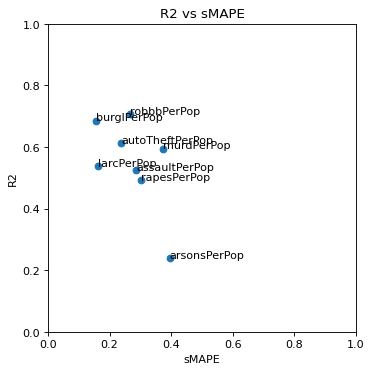

In [ ]:
# Plotting R2 vs sMAPE values for each crime category - ideal would be of high clustering
# of points with high R^2 value and low sMAPE
p = smape_single(s.inverse_transform(test_y), s.inverse_transform(model.predict(pca_testx)))
r = r2_score(s.inverse_transform(test_y), s.inverse_transform(model.predict(pca_testx)),multioutput = 'raw_values')

figure(figsize=(5, 5), dpi=80)

plt.scatter(p, r)
for i, txt in enumerate(targetCols):
    plt.annotate(txt, (p[i], r[i]), fontsize=10)

plt.title("R2 vs sMAPE")
plt.xlabel('sMAPE') 
plt.ylabel('R2')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

###Comparison with Simple Baseline (Linear Regression Model)

In [ ]:
#Display R^2 and sMAPE values each category + overall mean (Baseline)
pred = np.zeros((test_y.shape[0],len(targetCols)))

for i in range(len(targetCols)):
  y_sub = train_y[:,i]
  reg = LinearRegression().fit(pca_trainx, y_sub)
  pred[:,i] = reg.predict(pca_testx)

print('STATISTIC\tR^2\tsMAPE')
print('---------\t---\t-----')

for label, r, p in zip(targetCols, r2_score(s.inverse_transform(test_y), s.inverse_transform(pred),multioutput = 'raw_values'), smape_single(s.inverse_transform(test_y), s.inverse_transform(pred))):
    print(label, '{:5.3f}'.format(r), '{:5.3f}'.format(p), sep='\t')

r2_mean = r2_score(s.inverse_transform(test_y), s.inverse_transform(pred))
smape_mean = smape(s.inverse_transform(test_y), s.inverse_transform(pred))
print('\nMEAN\t\t{:5.3f}\t{:5.3f}'.format(r2_mean, smape_mean))

STATISTIC	R^2	sMAPE
---------	---	-----
murdPerPop	0.497	0.468
rapesPerPop	0.455	0.340
robbbPerPop	0.532	0.445
assaultPerPop	0.146	0.353
burglPerPop	0.652	0.174
larcPerPop	0.503	0.171
autoTheftPerPop	0.531	0.319
arsonsPerPop	0.236	0.423

MEAN		0.444	0.337


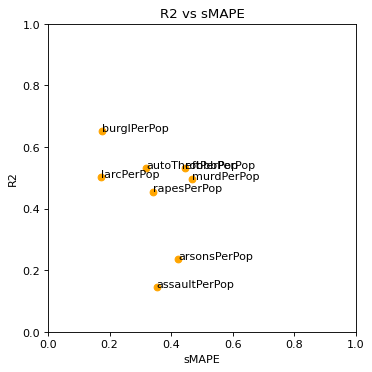

In [ ]:
# Plotting R2 vs sMAPE values for each crime category (Baseline) - ideal would be of high clustering
# of points with high R^2 value and low sMAPE

p = smape_single(s.inverse_transform(test_y), s.inverse_transform(pred))
r = r2_score(s.inverse_transform(test_y), s.inverse_transform(pred),multioutput = 'raw_values')

figure(figsize=(5, 5), dpi=80)

ax = plt.gca()

ax.scatter(p, r, color="orange")

for i, txt in enumerate(targetCols):
    ax.annotate(txt, (p[i], r[i]), fontsize=10)

plt.title("R2 vs sMAPE")
plt.xlabel('sMAPE') 
plt.ylabel('R2')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal', adjustable='box')

plt.show()